### Fine tunning to follow instructions

In [2]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data=file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [3]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [24]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else " "
    )
    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'? 

### Response:
An antonym of 'complicated' is 'simple'.


In [3]:
train_portion = int(len(data)*0.85)
test_portion = int(len(data)*0.1)
val_portion = len(data) - test_portion - train_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length", len(train_data))
print("Validation set length", len(val_data))
print("Testing set length:", len(test_data))

Training set length 935
Validation set length 55
Testing set length: 110


In [25]:
import torch
from torch.utils.data import Dataset
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))
    def __getitem__(self, index):
        return self.encoded_texts[index]
    def __len__(self):
        return len(self.data)

In [5]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [10]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_1st = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id]* (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        inputs_1st.append(inputs)
    inputs_tensor = torch.stack(inputs_1st).to(device)
    return inputs_tensor

In [11]:
inputs_1 = [0,1,2,3,4]
inputs_2 = [5,6]
inputs_3 = [ 7,8,9]
batch= (inputs_1, inputs_2,inputs_3)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [13]:
def custom_collate_draft_2(batch, pad_token_id=50256, device = "cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_1st, targets_1st = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_1st.append(inputs)
        targets_1st.append(targets)
    inputs_tensor = torch.stack(inputs_1st).to(device)
    targets_tensor = torch.stack(targets_1st).to(device)
    return inputs_tensor,  targets_tensor

In [14]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [15]:
def custom_collate_fn(batch, pad_token_id =50256, ignore_index=-100, allowed_max_length = None, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_1st, targets_1st = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id]* (batch_max_length - len(new_item)) )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel()>1:
            targets[indices[1:]] = ignore_index
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        inputs_1st.append(inputs)
        targets_1st.append(targets)
    inputs_tensor = torch.stack(inputs_1st).to(device)
    targets_tensor = torch.stack(targets_1st).to(device)
    return inputs_tensor, targets_tensor

In [16]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [17]:
logits_1 = torch.tensor([[-1.0, 1.0],[-0.5,1.5]])
targets_1 = torch.tensor([0,1])
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [19]:
logits_2 = torch.tensor([[-1.0, 1.0],[-0.5,1.5], [-0.5,1.5]])
targets_2 = torch.tensor([0,1,1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [20]:
targets_3 = torch.tensor([0,1,-100])
loss_3 = torch.nn.functional.cross_entropy(logits_2,targets_3)
print(loss_3)
print("loss_1==loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1==loss_3: tensor(True)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)
device = "cpu"

mps


In [35]:
from functools import partial
custom_collate_fn = partial(custom_collate_fn, device = device, allowed_max_length =1024)

In [36]:
from torch.utils.data import DataLoader
num_workers =0 
batch_size = 8
torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size= batch_size, collate_fn=custom_collate_fn, shuffle= True, num_workers=num_workers)
val_dataset =InstructionDataset(val_data,tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn,
                        shuffle=False, drop_last= False,
                        num_workers=num_workers)
test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         collate_fn=custom_collate_fn, shuffle=False,
                         drop_last=False,
                         num_workers=num_workers)

In [37]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 69]) torch.

In [38]:
from gpt_download import download_and_load_gpt2
from pretaining import GPTModel, load_weights_into_gpt
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length":1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768, "n_layers":12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim":1024, "n_layers":24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim":1280, "n_layers":36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim":1600, "n_layers":48, "n_heads": 25},
}
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size= model_size,
    models_dir= "gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [39]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.' 


In [40]:
from pretaining import generate, text_to_token_ids, token_ids_to_text
token_ids = generate(
    model= model,
    idx = text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [41]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

__________________________________________

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.' __________________________________________

### Instruction


In [42]:
from pretaining import (calc_loss_loader, train_model_simple)
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )
print("Traing loss:", train_loss)
print("Validation loss:", val_loss)

Traing loss: 3.8171589374542236
Validation loss: 3.76040997505188


In [43]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr =0.00005, weight_decay=0.1)
num_epochs =2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5, 
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time -start_time)/60
print(f"Training completed in {execution_time_minutes: .2f} minutes")

Ep 1 (Step000000):Train loss 2.747,Val loss  2.717
Ep 1 (Step000005):Train loss 1.229,Val loss  1.161
Ep 1 (Step000010):Train loss 0.868,Val loss  0.957
Ep 1 (Step000015):Train loss 0.859,Val loss  0.913
Ep 1 (Step000020):Train loss 0.780,Val loss  0.881
Ep 1 (Step000025):Train loss 0.744,Val loss  0.851
Ep 1 (Step000030):Train loss 0.790,Val loss  0.831
Ep 1 (Step000035):Train loss 0.714,Val loss  0.810
Ep 1 (Step000040):Train loss 0.664,Val loss  0.800
Ep 1 (Step000045):Train loss 0.632,Val loss  0.791
Ep 1 (Step000050):Train loss 0.660,Val loss  0.781
Ep 1 (Step000055):Train loss 0.758,Val loss  0.762
Ep 1 (Step000060):Train loss 0.717,Val loss  0.741
Ep 1 (Step000065):Train loss 0.649,Val loss  0.734
Ep 1 (Step000070):Train loss 0.531,Val loss  0.728
Ep 1 (Step000075):Train loss 0.568,Val loss  0.726
Ep 1 (Step000080):Train loss 0.613,Val loss  0.726
Ep 1 (Step000085):Train loss 0.506,Val loss  0.708
Ep 1 (Step000090):Train loss 0.557,Val loss  0.689
Ep 1 (Step000095):Train loss 0.

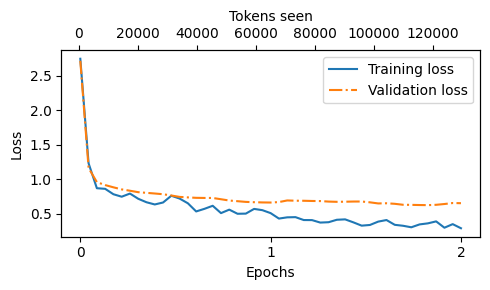

In [46]:
from pretaining import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses,val_losses)

In [47]:
torch.manual_seed(123)
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(model=model, 
                         idx = text_to_token_ids(input_text, tokenizer).to(device),
                         max_new_tokens=256,
                         context_size=BASE_CONFIG["context_length"],
                         eos_id=50256)
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("###Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("---------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> ### Response:
The car is as fast as a cheetah.
---------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms? 

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> ### Response:
A thunderstorm is a type of cloud that typically forms when thunderstorms are active.
---------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'. 

Correct response:
>> Jane Aust

In [48]:
from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx = text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("###Response:","")
        .strip()
    )
    test_data[i]["model_response"] = response_text
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent =4)

100%|██████████| 110/110 [05:23<00:00,  2.94s/it]


In [49]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': '### Response:\nThe car is as fast as a cheetah.'}


In [50]:
import re
file_name = f"{re.sub(r' [ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M)-sft.pth


### Evaluating the fine-tuned LLM


In [66]:
import psutil
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running
ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError(
        "Ollama not working.Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [72]:
import urllib.request
def query_model(prompt, model = "llama3",url = "http://localhost:11434/api/chat"
):
    data = {
        "model": model,
        "messages": [ {"role": "user", "content": prompt}],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx":2048
        }
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url, data= payload,
        method = "POST"
    )
    request.add_header("Content-Type", "application/json")
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True: 
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data 

In [73]:
model = "llama3"
result = query_model("What do llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Fresh fruits and veggies, such as apples, carrots, and sweet potatoes, are a tasty treat for llamas. They're also a good source of fiber, vitamins, and minerals.
5. Minerals: Llamas need access to mineral supplements, like salt licks or loose minerals, to ensure they receive the necessary nutrients.

In general, a llama's diet should consist of:

* 70-80% hay (high-quality grass hay or alfalfa)
* 10-20% grain

In [74]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}`"
        f"and correct output `{entry['output']}`,"
        f"score the model response `{entry['model_response']}`"
        f"on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n---------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> ### Response:
The car is as fast as a cheetah.

Score:
>> To score this model response, I'll compare it to the expected output.

Expected output: The car is as fast as lightning.
Model response: The car is as fast as a cheetah.

Similarity: Both responses use a simile ("as X as Y") and both comparisons are related to speed (lightning is extremely fast, and a cheetah is very fast). However, the expected output uses a more extreme example of speed (lightning) to emphasize just how fast the car is, whereas the model response uses a slightly less extreme example (a cheetah).

Score: 85

The model response is close to the expected output, but it's not quite as effective at conveying the idea that the car is extremely fast.

---------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> ### Response:
A thunderstorm is a type of cloud tha

In [78]:
def generate_modle_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc = "Scoring entries"):
        prompt = (
        f"Given the input `{format_input(entry)}`"
        f"and correct output `{entry['output']}`,"
        f"score the model response `{entry['model_response']}`"
        f"on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the integer number only."
    )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

In [79]:
scores = generate_modle_scores(test_data, "model_response")
print(f"Number of scores: { len(scores)} of {len(test_data)}")
print(f"Average score: { sum(scores)/ len(scores): .2f}\n")

Scoring entries: 100%|██████████| 110/110 [00:54<00:00,  2.00it/s]

Number of scores: 110 of 110
Average score:  54.04

